Используйте базу трафика с сайта компании.

Напишите модель для прогнозирования трафика.

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

Загрузка всех библиотек

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

Опишем параметры вывода графиков:

In [ ]:
# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

Загрузка датасета

In [ ]:
#Загружаем базу трафика с сайта компании
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/traff.csv', None, quiet=True)

'traff.csv'

In [ ]:
# Загрузка данных
data = pd.read_csv('traff.csv', header=None, names=['Datetime', 'Close'])
data

,Datetime,Close
0,1/1/2017,"22,226.00"
1,1/2/2017,"29,593.00"
2,1/3/2017,"31,726.00"
3,1/4/2017,"32,684.00"
4,1/5/2017,"31,820.00"
...,...,...
1090,12/27/2019,"29,801.00"
1091,12/28/2019,"34,913.00"
1092,12/29/2019,"37,665.00"
1093,12/30/2019,"32,643.00"


Преобразуем данные, избавимся от времени и дополним данные

In [ ]:
# Преобразование столбца даты в индекс таблицы и удаление столбца даты
data.index = pd.to_datetime(data['Datetime'])
data.drop(columns='Datetime', inplace=True)
data

,Close
Datetime,
2017-01-01,"22,226.00"
2017-01-02,"29,593.00"
2017-01-03,"31,726.00"
2017-01-04,"32,684.00"
2017-01-05,"31,820.00"
...,...
2019-12-27,"29,801.00"
2019-12-28,"34,913.00"
2019-12-29,"37,665.00"


In [ ]:
# Настройка имен столбцов
COL_DATE = 'Datetime'
COL_CLOSE = 'Close'

In [ ]:
# Поправим столбец с ценой
data['Close'] = data['Close'].str.replace('"', '').str.replace(',', '').astype(float) / 100
data

,Close
Datetime,
2017-01-01,222.26
2017-01-02,295.93
2017-01-03,317.26
2017-01-04,326.84
2017-01-05,318.20
...,...
2019-12-27,298.01
2019-12-28,349.13
2019-12-29,376.65


Посмотрим данные в графическом виде

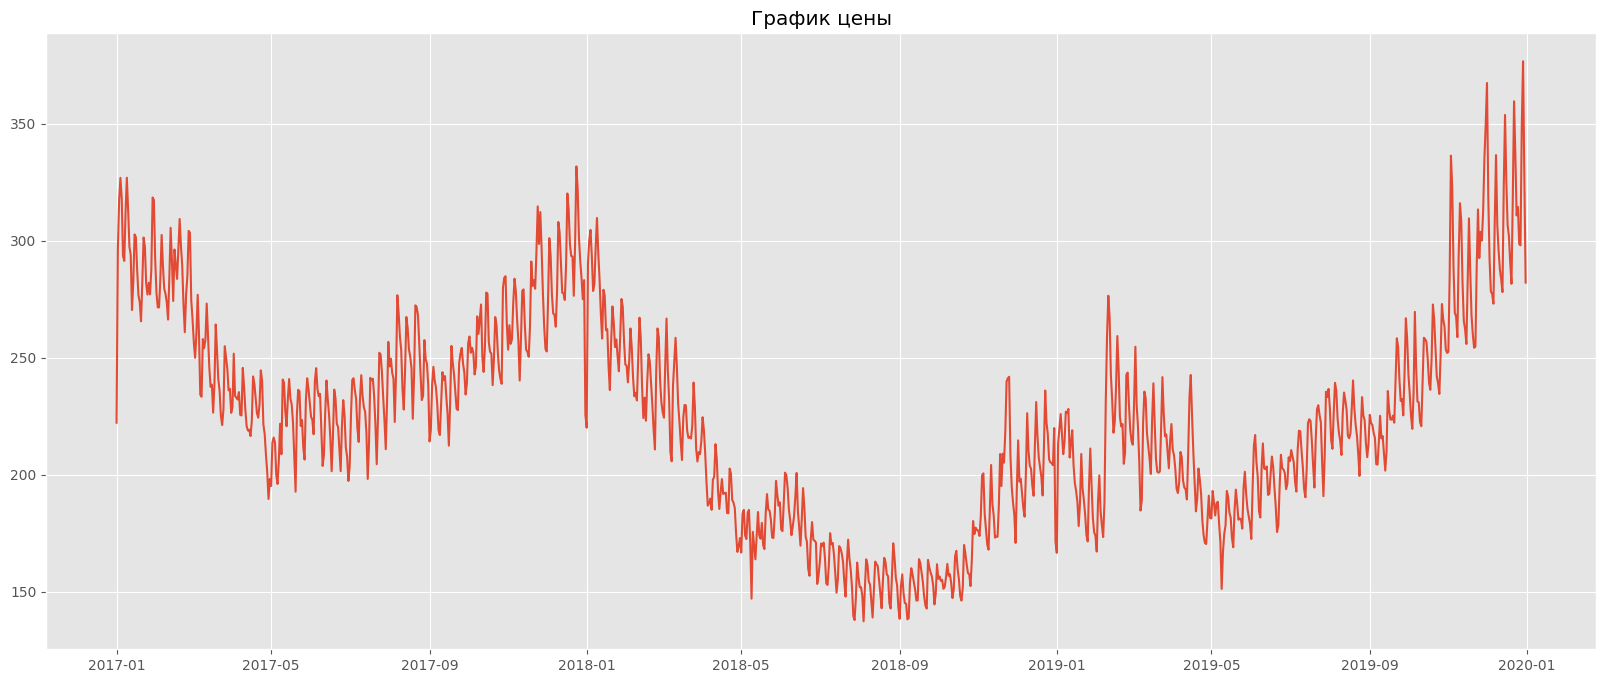

In [ ]:
# Отображение временного ряда в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(data.index, data[COL_CLOSE])
plt.title('График цены')
plt.show()

In [ ]:
# Задание гиперпараметров
INDICATOR_DEPTH = 6                       # Глубина расчета индикаторов тренда (шаги)
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания

In [ ]:
# Расчет индикаторов относительной доходности
for i in range(1, INDICATOR_DEPTH + 1):
    indicator_change = f'Close_chng_{i}'
    # Относительная доходность в сотых долях за период i шагов назад
    data[indicator_change] = data[COL_CLOSE].pct_change(i)

# Проверка результата
print(data.shape)
data[:5]

(1095, 7)


,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6
Datetime,,,,,,,
2017-01-01,222.26,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,295.93,0.331459,NaN,NaN,NaN,NaN,NaN
2017-01-03,317.26,0.072078,0.427427,NaN,NaN,NaN,NaN
2017-01-04,326.84,0.030196,0.104450,0.470530,NaN,NaN,NaN
2017-01-05,318.20,-0.026435,0.002963,0.075254,0.431657,NaN,NaN


In [ ]:
# Удаление строк с неполными данными
data.dropna(inplace=True)

# Проверка результата
print(data.shape)
data[:5]

(1089, 7)


,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6
Datetime,,,,,,,
2017-01-07,291.39,-0.007324,-0.084255,-0.108463,-0.081542,-0.015341,0.311032
2017-01-08,312.44,0.072240,0.064386,-0.018102,-0.044058,-0.015193,0.055790
2017-01-09,326.90,0.046281,0.121864,0.113647,0.027341,0.000184,0.030385
2017-01-10,312.99,-0.042551,0.001760,0.074127,0.066260,-0.016373,-0.042375
2017-01-11,297.38,-0.049874,-0.090303,-0.048201,0.020557,0.013082,-0.065431


In [ ]:
# 1. Разделение 80 / 10 / 10
total_len = len(data)
train_end = int(total_len * 0.8)
val_end   = int(total_len * 0.9)

train_df = data.iloc[:train_end]
val_df   = data.iloc[train_end:val_end]
test_df  = data.iloc[val_end:]

In [ ]:
# 2. Масштабирование (отдельно признаки и цель)
feature_scaler = MinMaxScaler()
target_scaler  = MinMaxScaler()

X_train = feature_scaler.fit_transform(train_df)
X_val   = feature_scaler.transform(val_df)
X_test  = feature_scaler.transform(test_df)

y_train = target_scaler.fit_transform(train_df[['Close']])
y_val   = target_scaler.transform(val_df[['Close']])
y_test  = target_scaler.transform(test_df[['Close']])

In [ ]:
# 3. TimeseriesGenerator
seq_len   = 60      # «длина истории» для одного примера
batch_sz  = 20

train_gen = TimeseriesGenerator(X_train, y_train,
                                length=seq_len, stride=1,
                                sampling_rate=1, batch_size=batch_sz)

val_gen   = TimeseriesGenerator(X_val, y_val,
                                length=seq_len, stride=1,
                                sampling_rate=1, batch_size=batch_sz)

test_gen  = TimeseriesGenerator(X_test, y_test,
                                length=seq_len, stride=1,
                                sampling_rate=1, batch_size=1)

In [ ]:
# 4. Модель LSTM
model_lstm = Sequential([
    LSTM(5, input_shape=(seq_len, X_train.shape[1])),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])
model_lstm.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')

In [ ]:
# 5. Обучение (20 эпох)
history = model_lstm.fit(train_gen,
                         epochs=20,
                         validation_data=val_gen,
                         verbose=2)

Epoch 1/20
41/41 - 3s - 82ms/step - loss: 0.0836 - val_loss: 0.0554
Epoch 2/20
41/41 - 1s - 19ms/step - loss: 0.0827 - val_loss: 0.0544
Epoch 3/20
41/41 - 1s - 19ms/step - loss: 0.0819 - val_loss: 0.0535
Epoch 4/20
41/41 - 1s - 19ms/step - loss: 0.0811 - val_loss: 0.0525
Epoch 5/20
41/41 - 1s - 19ms/step - loss: 0.0803 - val_loss: 0.0515
Epoch 6/20
41/41 - 1s - 25ms/step - loss: 0.0795 - val_loss: 0.0507
Epoch 7/20
41/41 - 1s - 34ms/step - loss: 0.0787 - val_loss: 0.0498
Epoch 8/20
41/41 - 1s - 23ms/step - loss: 0.0780 - val_loss: 0.0489
Epoch 9/20
41/41 - 1s - 18ms/step - loss: 0.0772 - val_loss: 0.0480
Epoch 10/20
41/41 - 1s - 18ms/step - loss: 0.0764 - val_loss: 0.0472
Epoch 11/20
41/41 - 1s - 19ms/step - loss: 0.0757 - val_loss: 0.0462
Epoch 12/20
41/41 - 1s - 18ms/step - loss: 0.0750 - val_loss: 0.0453
Epoch 13/20
41/41 - 1s - 18ms/step - loss: 0.0742 - val_loss: 0.0446
Epoch 14/20
41/41 - 1s - 18ms/step - loss: 0.0735 - val_loss: 0.0437
Epoch 15/20
41/41 - 1s - 18ms/step - loss: 

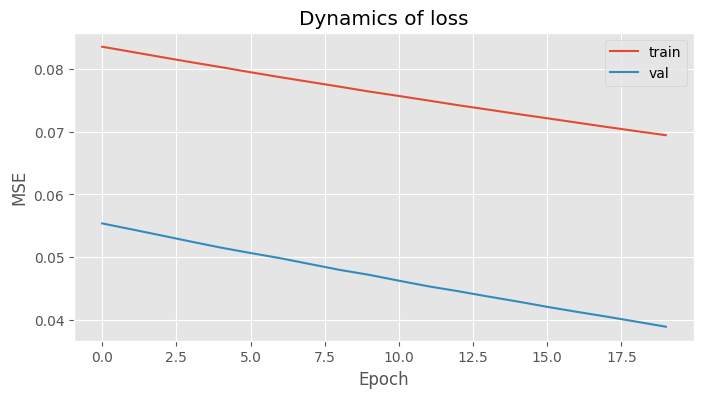

In [ ]:
# 6. График ошибки
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Dynamics of loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
# ----- Служебные функции для прогноза и визуализации -----
def get_pred(model, generator, scaler_y):
    """Возвратить предсказание и истину в исходном масштабе."""
    y_pred_scaled = model.predict(generator).flatten().reshape(-1, 1)
    y_true_scaled = np.concatenate([y for _, y in generator]).reshape(-1, 1)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler_y.inverse_transform(y_true_scaled).flatten()
    return y_pred, y_true

def show_predict(y_pred, y_true, start=0, length=300,
                 title='Прогноз LSTM vs Факт'):
    end = start + length
    plt.figure(figsize=(14,4))
    plt.plot(y_true[start:end], label='Факт')
    plt.plot(y_pred[start:end], label='Прогноз')
    plt.title(title)
    plt.xlabel('Относительный индекс времени')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

In [ ]:
def show_corr(y_pred, y_true, back_steps_max=30,
              title='Кросс-/автокорреляции'):
    steps = range(0, back_steps_max + 1)
    cross_corr = [correlate(y_true[:-s or None], y_pred[s:]) for s in steps]
    auto_corr  = [correlate(y_true[:-s or None], y_true[s:]) for s in steps]
    plt.figure(figsize=(10,5))
    plt.plot(steps, cross_corr, marker='o', label='Прогноз vs Факт')
    plt.plot(steps, auto_corr,  marker='o', label='Факт vs Факт')
    plt.xticks(steps)
    plt.xlabel('Смещение (шагов)')
    plt.ylabel('Коэффициент корреляции')
    plt.title(title)
    plt.legend()
    plt.show()

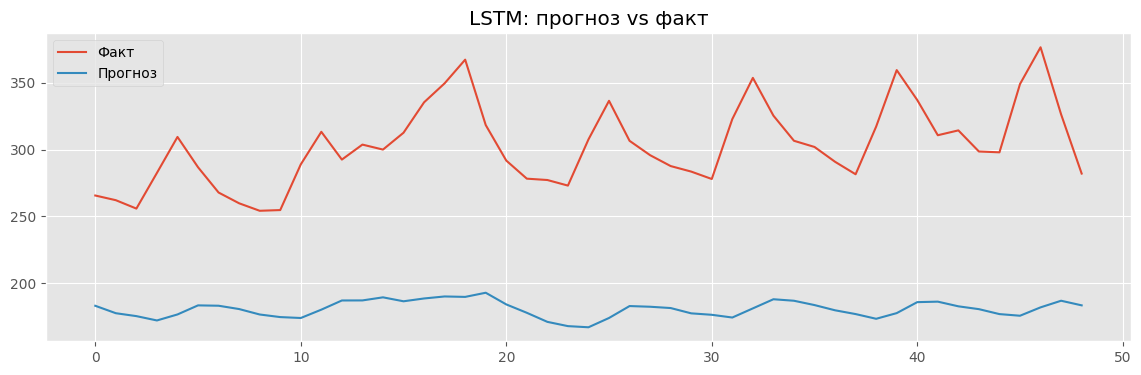

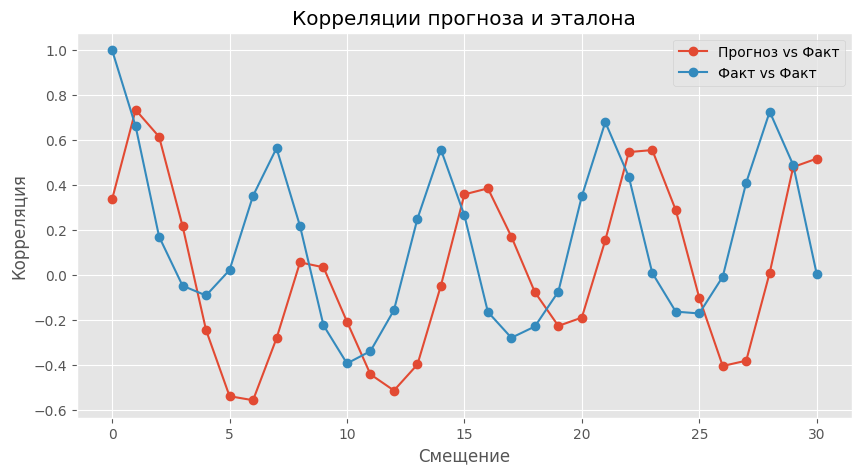

In [ ]:
# 7. Безопасное предсказание на тесте (без генератора)
# Получаем входы и цели вручную из X_test и y_test
X_test_seq = np.array([X_test[i - seq_len:i] for i in range(seq_len, len(X_test))])
y_test_seq = y_test[seq_len:]

# Прогноз (в масштабе)
y_pred_scaled = model_lstm.predict(X_test_seq, batch_size=32, verbose=0)

# Обратное масштабирование
y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
y_true = target_scaler.inverse_transform(y_test_seq).flatten()

# Отобразим только первые 500 точек
plot_len = min(500, len(y_pred))

plt.figure(figsize=(14, 4))
plt.plot(y_true[:plot_len], label='Факт')
plt.plot(y_pred[:plot_len], label='Прогноз')
plt.title('LSTM: прогноз vs факт')
plt.legend()
plt.show()

# Корреляции (только на 500 точках)
def safe_correlate(a, b):
    return np.corrcoef(a, b)[0, 1] if len(a) > 1 else 0

steps = range(0, 30 + 1)
cross_corr = [safe_correlate(y_true[:plot_len - s], y_pred[s:plot_len]) for s in steps]
auto_corr =  [safe_correlate(y_true[:plot_len - s], y_true[s:plot_len]) for s in steps]

plt.figure(figsize=(10, 5))
plt.plot(steps, cross_corr, marker='o', label='Прогноз vs Факт')
plt.plot(steps, auto_corr, marker='o', label='Факт vs Факт')
plt.title('Корреляции прогноза и эталона')
plt.xlabel('Смещение')
plt.ylabel('Корреляция')
plt.legend()
plt.show()